In [1]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy

from modisco.visualization import viz_sequence
import keras.backend as K

Using TensorFlow backend.


In [2]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll
import matplotlib.pyplot as plt

In [3]:
# local
#sys.path.append("/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/")
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/srv/scratch/anusri/chrombpnet_paper/src/utils/one_hot.py'>

In [4]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gc_neg_peaks =  pd.read_csv("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/negatives_data/bpnet.inputs.all.negatives.bed", # these are non-peaks for fibroblast scATAC pseudo-bulk
                           sep='\t',
                           names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"])
print(gc_neg_peaks.shape)
gc_neg_peaks.head()

(270286, 10)


,chr,start,end,1,2,3,4,5,6,summit
0,chr9,127108857,127108859,.,2,.,.,.,.,1
1,chr22,39431257,39431259,.,2,.,.,.,.,1
2,chr22,44272007,44272009,.,2,.,.,.,.,1
3,chr9,113089657,113089659,.,2,.,.,.,.,1
4,chr22,37343307,37343309,.,2,.,.,.,.,1


In [6]:
gc_neg_peaks = gc_neg_peaks.sample(n=25000, replace=True, random_state=1)
print(gc_neg_peaks.shape)




(25000, 10)


In [7]:
train_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]!="chr1")&(gc_neg_peaks["chr"]!="chr2")]
val_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]=="chr2")]
test_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]=="chr1")]






In [8]:
train_peaks.shape[0] + val_peaks.shape[0] + test_peaks.shape[0]





25000

In [9]:
fibr_45_bw = pyBigWig.open("/oak/stanford/groups/akundaje/refs/backgrounds_accesibility/DNASE_background_hg38/ENCODE.DNASE.merged.bpnet.unstranded.bw") # +4/-5 shifted
fibr_44_bw = pyBigWig.open("/oak/stanford/groups/akundaje/projects/chrombpnet/model_inputs/ATAC/K562.filtered.merged.bam.unstranded.bw") # +4/-4 shifted




In [10]:
def get_cts(bw, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        try:
            vals.append(np.nan_to_num(bw.values(r['chr'], 
                                                (r['start'] + r['summit'])- width//2,
                                                (r['start'] + r['summit']) + width//2)))
        except:
            print((r['start'] + r['summit'])- width//2, (r['start'] + r['summit']) + width//2)
        
    return np.array(vals)

In [11]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        seq = str(genome[r['chr']][(r['start'] + r['summit']) - width//2:(r['start'] + r['summit']) + width//2])
        if len(seq) == 2000:
            vals.append(seq)
        else:
            print((r['start'] + r['summit'])- width//2, (r['start'] + r['summit']) + width//2)
        
    return one_hot.dna_to_one_hot(vals)

In [12]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [13]:
train_45_cts = get_cts(fibr_45_bw, train_peaks)
val_45_cts = get_cts(fibr_45_bw, val_peaks)
test_45_cts = get_cts(fibr_45_bw, test_peaks)

train_44_cts = get_cts(fibr_44_bw, train_peaks)
val_44_cts = get_cts(fibr_44_bw, val_peaks)
test_44_cts = get_cts(fibr_44_bw, test_peaks)






In [14]:
train_seqs = get_seq(hg38, train_peaks)
val_seqs = get_seq(hg38, val_peaks)
test_seqs = get_seq(hg38, test_peaks)





In [15]:
train_seqs.shape


(20078, 2000, 4)

In [16]:
def simple_model():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(1, 100, padding='same')(inp)
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=inp, outputs=x)





In [17]:
def get_jsd(preds, cts, min_sum=10):
    return np.array([scipy.spatial.distance.jensenshannon(x,y) for x,y in zip(preds, cts) \
                     if y.sum()>min_sum])






In [18]:
model_45 = simple_model()
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
model_44 = simple_model()





In [19]:
model_45.compile(
    optimizer="adam",
    loss=multinomial_nll,
)

model_44.compile(
    optimizer="adam",
    loss=multinomial_nll,
)





In [20]:
model_45.fit(train_seqs,
          train_45_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_45_cts),
          shuffle=True)






Epoch 1/50
20/20 [==============================] - 1s 48ms/step - loss: 31662.2168 - val_loss: 28974.3574
Epoch 2/50
20/20 [==============================] - 1s 26ms/step - loss: 28175.1289 - val_loss: 26345.6426
Epoch 3/50
20/20 [==============================] - 1s 30ms/step - loss: 25964.0840 - val_loss: 24694.1133
Epoch 4/50
20/20 [==============================] - 1s 27ms/step - loss: 24558.4355 - val_loss: 23607.2695
Epoch 5/50
20/20 [==============================] - 1s 27ms/step - loss: 23606.0820 - val_loss: 22834.6973
Epoch 6/50
20/20 [==============================] - 1s 26ms/step - loss: 22905.4688 - val_loss: 22244.5957
Epoch 7/50
20/20 [==============================] - 1s 28ms/step - loss: 22358.1816 - val_loss: 21765.1367
Epoch 8/50
20/20 [==============================] - 1s 29ms/step - loss: 21904.1582 - val_loss: 21363.0859
Epoch 9/50
20/20 [==============================] - 1s 26ms/step - loss: 21519.8926 - val_loss: 21017.0312
Epoch 10/50
20/20 [==================

In [21]:

model_44.fit(train_seqs,
          train_44_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_44_cts),
          shuffle=True)




Epoch 1/50
20/20 [==============================] - 1s 42ms/step - loss: 862.8905 - val_loss: 776.7172
Epoch 2/50
20/20 [==============================] - 1s 29ms/step - loss: 824.1949 - val_loss: 746.8724
Epoch 3/50
20/20 [==============================] - 1s 27ms/step - loss: 794.5673 - val_loss: 723.6735
Epoch 4/50
20/20 [==============================] - 1s 29ms/step - loss: 771.1046 - val_loss: 705.0118
Epoch 5/50
20/20 [==============================] - 1s 33ms/step - loss: 752.0059 - val_loss: 689.3794
Epoch 6/50
20/20 [==============================] - 1s 31ms/step - loss: 735.7917 - val_loss: 676.1106
Epoch 7/50
20/20 [==============================] - 1s 29ms/step - loss: 721.9141 - val_loss: 664.6065
Epoch 8/50
20/20 [==============================] - 1s 29ms/step - loss: 709.8436 - val_loss: 654.5139
Epoch 9/50
20/20 [==============================] - 1s 28ms/step - loss: 699.2526 - val_loss: 645.6116
Epoch 10/50
20/20 [==============================] - 0s 25ms/step - loss:

In [22]:
np.median(get_jsd(softmax(model_45.predict(test_seqs)), test_45_cts))


0.25865416490655435

In [23]:
np.median(get_jsd(softmax(model_44.predict(test_seqs)), test_44_cts))



0.6037614636452868

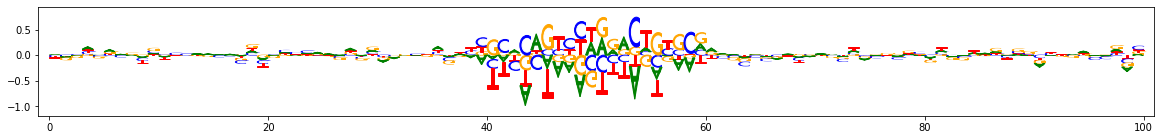

In [24]:
viz_sequence.plot_weights(model_44.layers[1].get_weights()[0][:,:,0], subticks_frequency=20)


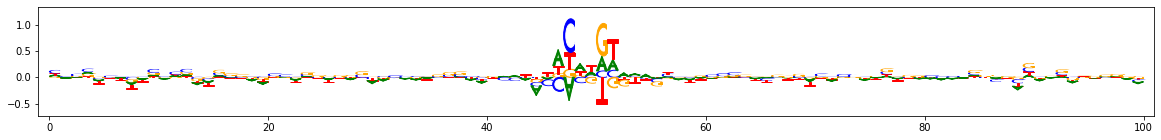

In [25]:
viz_sequence.plot_weights(model_45.layers[1].get_weights()[0][:,:,0], subticks_frequency=20)


In [26]:
def model_3conv():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(50, 100, padding='same')(inp)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv1D(20, 100, padding='same')(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv1D(2, 100, padding='same')(x)
    x = tf.keras.layers.Dense(1, activation='relu')(x)
    
    x = tf.keras.layers.Flatten()(x)

    return tf.keras.Model(inputs=inp, outputs=x)

In [27]:
model_complex = model_3conv()


In [28]:
model_complex.compile(
    optimizer="adam",
    loss=multinomial_nll,
)

In [29]:
model_complex.fit(train_seqs,
          train_44_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_44_cts),
          shuffle=True)

Epoch 1/50
20/20 [==============================] - 5s 236ms/step - loss: 699.8802 - val_loss: 590.3759
Epoch 2/50
20/20 [==============================] - 4s 176ms/step - loss: 628.6638 - val_loss: 582.1918
Epoch 3/50
20/20 [==============================] - 4s 178ms/step - loss: 621.9203 - val_loss: 576.7919
Epoch 4/50
20/20 [==============================] - 4s 186ms/step - loss: 617.2752 - val_loss: 573.3440
Epoch 5/50
20/20 [==============================] - 4s 188ms/step - loss: 613.3380 - val_loss: 569.1788
Epoch 6/50
20/20 [==============================] - 4s 179ms/step - loss: 608.2840 - val_loss: 563.9327
Epoch 7/50
20/20 [==============================] - 4s 185ms/step - loss: 602.4833 - val_loss: 558.3552
Epoch 8/50
20/20 [==============================] - 4s 179ms/step - loss: 596.2225 - val_loss: 552.4106
Epoch 9/50
20/20 [==============================] - 4s 179ms/step - loss: 590.0873 - val_loss: 547.0124
Epoch 10/50
20/20 [==============================] - 4s 184ms/st

KeyboardInterrupt: 

In [ ]:
np.median(get_jsd(softmax(model_complex.predict(test_seqs)), test_44_cts))


In [ ]:
for i in [1,2,8,11,16]:
    viz_sequence.plot_weights(model_complex.layers[1].get_weights()[0][:,:,i], subticks_frequency=20)